# Projet : Statistique en Grande Dimension - Exercice 1

Solène Lesage

## Deuxième partie

### Importer packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import plotly
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, KFold, GridSearchCV, train_test_split, cross_val_predict, cross_val_score, validation_curve


### Question 1 : Proposer et mettre en œuvre des variantes de l'algorithme Gradient Boosting et les tester.

#### Importer la base de données MNIST

On va utiliser une partie de la base de données MNIST. Il s'agit d'une base de données de chiffres écrits à la main. Elle regroupe 59999 images d’apprentissage et 9999 images de test. Ce sont des images en noir et blanc, normalisées centrées de 28 pixels de côté.

Comme nous ne souhaitons pas visualiser les images, nous n'avons pas besoin de redimensionner chaque ligne en une matrice de 28 par 28 pixels.

Nous sommes ici dans un problème de classification car nous devons classifier les chiffres sur les différentes possibilités de 0 à 9. Ainsi, il y a 10 classes.

On pourra tester l'algorithme Gradient Boosting sur ces données ainsi qu'utiliser différentes variantes à savoir : XGBoost, LightGBM et CatBoost.

Puis, on pourra également évaluer la qualité des modèles en utilisant des métriques pour la classification comme l'accuracy, les faux positifs, les faux négatifs, une matrice de confusion, la précision, le rappel ainsi que le F1-score.

In [2]:
datatrain = pd.read_csv("mnist_train.csv")
datatrain.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print(f"Le jeu de données possède {datatrain.shape[0]} individus et {datatrain.shape[1]} variables.")

Le jeu de données possède 59999 individus et 785 variables.


In [4]:
datatest = pd.read_csv("mnist_test.csv")
datatest.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(f"Le jeu de données possède {datatest.shape[0]} individus et {datatest.shape[1]} variables.")

Le jeu de données possède 9999 individus et 785 variables.


In [6]:
print(f"Le jeu de données train possède {datatrain.isnull().sum().sum()} valeur manquante.")
print(f"Le jeu de données test possède {datatest.isnull().sum().sum()} valeur manquante.")

Le jeu de données train possède 0 valeur manquante.
Le jeu de données test possède 0 valeur manquante.


In [7]:
datatrain.dtypes

5        int64
0        int64
0.1      int64
0.2      int64
0.3      int64
         ...  
0.613    int64
0.614    int64
0.615    int64
0.616    int64
0.617    int64
Length: 785, dtype: object

Les jeux de données train et test n'ont pas besoin d'être pré-traités. Ils n'ont pas de valeurs manquantes et les variables sont toutes quantitatives.

### Pré-traitement des données

In [8]:
datatrain_copy = datatrain.copy()
datatest_copy = datatest.copy()

In [9]:
# On ne va pas utiliser toutes les données (seulement les 12000 premières pour le jeu train et les 2000 premières pour le jeu test)
# On a réduit de 1/5 les données pour faciliter les temps d'exécution des modèles qui sont parfois très long.

#Train
y_train = datatrain_copy.iloc[:,[0]]
y_train = y_train.iloc[:12000]
y_train = y_train.values

X_train = datatrain_copy.drop(datatrain_copy.columns[0], axis=1) # on enlève la variable y dans le jeu de données train
X_train = X_train.iloc[:12000]
X_train = X_train.values

#Test
y_test = datatest_copy.iloc[:,[0]]
y_test = y_test.iloc[:2000]
y_test = y_test.values

X_test = datatest_copy.drop(datatest_copy.columns[0], axis=1) # on enlève la variable y dans le jeu de données test
X_test = X_test.iloc[:2000]
X_test = X_test.values

### Algorithme Gradient Boosting

#### Première version : paramètres par défaut

In [10]:
# Fonction de perte la déviance
gradient_booster = GradientBoostingClassifier(loss='deviance')

In [11]:
gradient_booster.fit(X_train, y_train)

GradientBoostingClassifier(loss='deviance')

In [12]:
y_pred = gradient_booster.predict(X_test)

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       175
           1       0.96      0.98      0.97       234
           2       0.93      0.89      0.91       219
           3       0.89      0.85      0.87       207
           4       0.91      0.90      0.90       217
           5       0.86      0.87      0.86       179
           6       0.90      0.88      0.89       179
           7       0.89      0.87      0.88       204
           8       0.84      0.85      0.84       192
           9       0.84      0.89      0.86       194

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [14]:
print("Accuracy score (train): {0:.2f}".format(gradient_booster.score(X_train, y_train)))
print("Accuracy score (validation): {0:.2f}".format(gradient_booster.score(X_test, y_test)))

Accuracy score (train): 0.99
Accuracy score (validation): 0.90


On obtient un très bon score accuracy de 0.90 pour la validation.
Et, un score de 0.99 pour le score train, cela ressemble peut-être à du sur-apprentissage malgrè une très bonne erreur de valaidation.

In [15]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[170   0   0   0   0   0   3   0   2   0]
 [  0 230   0   0   0   0   2   0   2   0]
 [  1   0 195   4   2   1   3   4   6   3]
 [  0   0   3 176   1  10   1   8   5   3]
 [  0   1   0   1 195   1   4   1   3  11]
 [  3   0   1   4   3 156   1   2   4   5]
 [  4   3   0   0   2   8 158   0   4   0]
 [  0   3   7   1   2   2   0 178   2   9]
 [  1   1   4   7   4   3   4   2 163   3]
 [  1   1   0   5   5   1   0   5   3 173]]


In [16]:
# Il y a beaucoup de paramètres à optimiser
gradient_booster.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

On pourrait chercher à explorer séparamment les paramètres les plus importants :
- le nombre d'arbres (n_estimators) par défaut est fixé à 100
- le nombre d'échantillons pour fit les données (subsample), par défaut est fixé à 1
- le nombre de features pour chaque arbres (max_features), par défaut toutes les features
- le learning rate pour les prédictions (learning_rate) fixé à 0.1 par défaut
- la profondeur de l'arbre pour le dataset d'entrainement (max_depth) fixé à 3 par défaut

Mais on va chercher à optimiser tous ces hyperparamètres en même temps en utilisant GridSearchCV.



#### Représentation graphique du score en fonction du nombre d'estimateurs

In [22]:
model = GradientBoostingClassifier(loss='deviance',learning_rate=0.1, max_features=4, max_depth=3, random_state=0)
param_range = [1, 2, 5, 10, 20, 50, 100]

train_scores, validation_scores = validation_curve(
    model,
    X_train,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=-1,
)

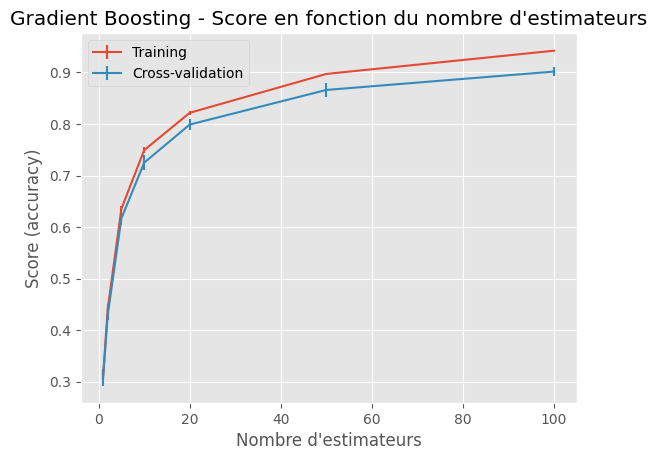

In [23]:
plt.errorbar(
    param_range,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    label="Training",
)
plt.errorbar(
    param_range,
    validation_scores.mean(axis=1),
    yerr=validation_scores.std(axis=1),
    label="Cross-validation",
)
plt.title("Gradient Boosting - Score en fonction du nombre d'estimateurs")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Score (accuracy)")
plt.legend(loc="best")
plt.show()

Plus le nombre d'estimateurs (d'arbres) augmentent, plus les scores train et test sont meilleurs et tendent vers 1.
La courbe de score test est au dessous de celle du score train, ce qui cohérent.

In [24]:
model2 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, max_depth=3, max_features=4, random_state=0)
param_range = [1, 2, 3, 5, 7, 9]
train_scores2, validation_scores2 = validation_curve(
    model2,
    X_train,
    y_train,
    param_name="max_depth",
    param_range=param_range,
    scoring="accuracy",
    n_jobs=-1,
)

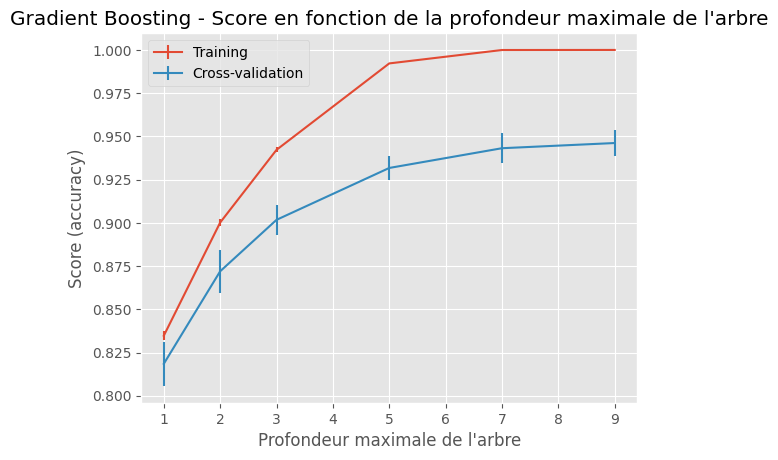

In [25]:
plt.errorbar(
    param_range,
    train_scores2.mean(axis=1),
    yerr=train_scores2.std(axis=1),
    label="Training",
)
plt.errorbar(
    param_range,
    validation_scores2.mean(axis=1),
    yerr=validation_scores2.std(axis=1),
    label="Cross-validation",
)
plt.title("Gradient Boosting - Score en fonction de la profondeur maximale de l'arbre")
plt.xlabel("Profondeur maximale de l'arbre")
plt.ylabel("Score (accuracy)")
plt.legend(loc="best")
plt.show()

On observe ici que le score est très performant suivant la profondeur maximale de l'arbre.
On remarque que l'erreur de validation stagne. Pour éviter le sur-apprentissage, on choisit de prendre une profondeur maximale de 2 ou 3.

#### Optimation des paramètres avec GridSearchCV

In [26]:
model = GradientBoostingClassifier(loss='deviance')

# Grille des valeurs qu'on souhaite tester pour nos modèles
grid = dict()
grid['n_estimators'] = [10, 20, 50, 100]
#grid['subsample'] = [0.5, 0.7, 1.0]
grid['max_features'] = [2, 3, 4]
grid['learning_rate'] = [0.01, 0.1, 1.0]
grid['max_depth'] = [2, 3, 7, 9]

# Procédure d'évaluation en utilisant une 'repeated k-fold cross-validation'
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# On se base sur le score accuracy
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, verbose=1, cv=cv, scoring='accuracy')

grid_result = grid_search.fit(X_train, y_train)

Fitting 15 folds for each of 144 candidates, totalling 2160 fits


In [27]:
# Résumé du meilleur score avec ses paramètres correspondants
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.948389 using {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 4, 'n_estimators': 100}


In [ ]:
# On cherche le meilleur modèle
print('\n\nEstimateur choisi par GridSearch :','\n\n', (grid_result.best_estimator_))

Le meilleur modèle est donné avec les paramètres suivants :
- loss = deviance
- learning_rate = 0.1
- max_depth = 9
- max_features = 4
- n_estimators = 100

qui donne un score de 0.95.
Celui-ci est moins bon que pour le modèle précédent sans ajustement des paramètres.

Regardons les prédictions de ce nouveau modèle.

#### Meilleur modèle

In [32]:
gradient_booster_best = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, max_depth=9, max_features=4, n_estimators=100, random_state=0)

In [33]:
gradient_booster_best.fit(X_train, y_train)

GradientBoostingClassifier(loss='deviance', max_depth=9, max_features=4,
                           random_state=0)

In [35]:
y_pred = gradient_booster_best.predict(X_test)

In [36]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[174   0   0   0   0   0   1   0   0   0]
 [  0 231   1   0   1   0   1   0   0   0]
 [  2   0 202   4   1   0   1   4   3   2]
 [  0   0   2 191   0   4   1   4   3   2]
 [  1   0   2   0 200   0   2   0   0  12]
 [  1   0   0   8   2 165   0   1   0   2]
 [  3   1   0   0   3   3 167   0   2   0]
 [  0   4   8   3   1   0   0 179   0   9]
 [  2   1   2   8   5   2   0   1 166   5]
 [  1   0   0   6   5   0   0   2   4 176]]


In [37]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       175
           1       0.97      0.99      0.98       234
           2       0.93      0.92      0.93       219
           3       0.87      0.92      0.89       207
           4       0.92      0.92      0.92       217
           5       0.95      0.92      0.93       179
           6       0.97      0.93      0.95       179
           7       0.94      0.88      0.91       204
           8       0.93      0.86      0.90       192
           9       0.85      0.91      0.88       194

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



Ce score est meilleur que celui du premier modèle sans ajustement des paramètres.
Il est de 0.93 contre 0.90 pour le premier.

On remarque tout de même que la méthode Gradient Boosting est très performante.

### Algorithme XGBoost

In [38]:
model = XGBClassifier(use_label_encoder=False, num_class=10)

eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(X_train, y_train, eval_metric=['mlogloss'], eval_set=eval_set)

[0]	validation_0-mlogloss:1.33845	validation_1-mlogloss:1.48367
[1]	validation_0-mlogloss:0.99538	validation_1-mlogloss:1.18329
[2]	validation_0-mlogloss:0.77389	validation_1-mlogloss:0.97986
[3]	validation_0-mlogloss:0.61389	validation_1-mlogloss:0.83560
[4]	validation_0-mlogloss:0.49192	validation_1-mlogloss:0.72145
[5]	validation_0-mlogloss:0.39851	validation_1-mlogloss:0.63522
[6]	validation_0-mlogloss:0.32595	validation_1-mlogloss:0.56575
[7]	validation_0-mlogloss:0.26981	validation_1-mlogloss:0.51189
[8]	validation_0-mlogloss:0.22457	validation_1-mlogloss:0.46800
[9]	validation_0-mlogloss:0.18730	validation_1-mlogloss:0.43009
[10]	validation_0-mlogloss:0.15837	validation_1-mlogloss:0.40370
[11]	validation_0-mlogloss:0.13410	validation_1-mlogloss:0.38016
[12]	validation_0-mlogloss:0.11512	validation_1-mlogloss:0.36094
[13]	validation_0-mlogloss:0.09929	validation_1-mlogloss:0.34162
[14]	validation_0-mlogloss:0.08532	validation_1-mlogloss:0.32585
[15]	validation_0-mlogloss:0.07424	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', ...)

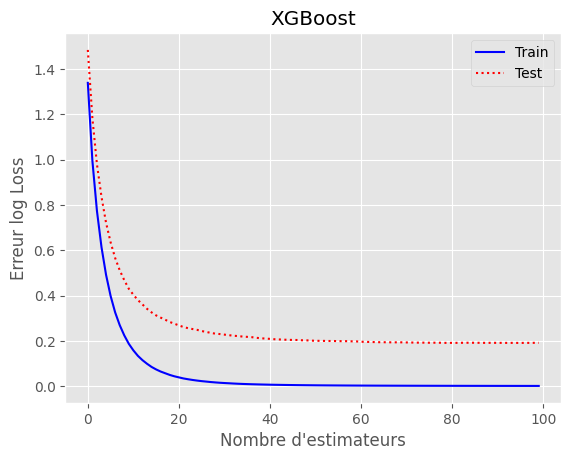

In [51]:
results = model.evals_result()

fig, ax = plt.subplots()

epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train',color='blue')
ax.plot(x_axis, results['validation_1']['mlogloss'], ':', label='Test',color='red')
ax.legend()
plt.xlabel("Nombre d'estimateurs")
plt.ylabel('Erreur log Loss')
plt.title('XGBoost')
plt.show()

In [52]:
scores_val_cross = cross_val_score(model, X_train, y_train, cv=5)

In [53]:
print("Mean cross-validation score %.2f" % scores_val_cross.mean())

Mean cross-validation score 0.95


In [54]:
y_pred = cross_val_predict(model, X_test, y_test, cv=5)

In [55]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[167   0   0   0   0   0   4   0   4   0]
 [  0 226   1   1   2   0   2   0   2   0]
 [  2   3 191   2   5   0   6   5   3   2]
 [  0   1   3 172   0   6   2  11  11   1]
 [  1   0   1   1 193   0   2   1   3  15]
 [  7   1   0   6   3 149   5   2   6   0]
 [  5   1   3   0   3   3 157   1   6   0]
 [  1   2   9   3   4   1   0 176   1   7]
 [  0   3   4   6   6   9   3   3 153   5]
 [  1   0   1   4   7   2   0   7   2 170]]


<AxesSubplot: >

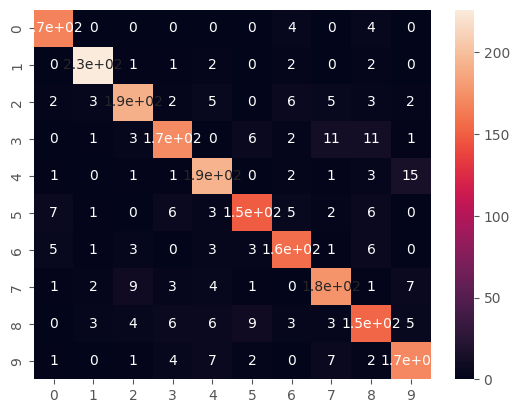

In [56]:
sns.heatmap(cm, annot=True)

In [57]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       175
           1       0.95      0.97      0.96       234
           2       0.90      0.87      0.88       219
           3       0.88      0.83      0.86       207
           4       0.87      0.89      0.88       217
           5       0.88      0.83      0.85       179
           6       0.87      0.88      0.87       179
           7       0.85      0.86      0.86       204
           8       0.80      0.80      0.80       192
           9       0.85      0.88      0.86       194

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



In [58]:
print("Accuracy score (validation) : %.2f" % round(accuracy_score(y_test, y_pred),2))

Accuracy score (validation) : 0.88


On obtient un score plutôt bon, mais moins bon que le meilleur modèle avec l'algorithme Gradient Boosting. 

On va alors chercher à l'optimiser.

Pour cela, on va commencer par utiliser le early_stopping en le fixant à 10 pour limiter la complexité du modèle et pour éviter le sur-apprentissage.

In [59]:
eval_set = [(X_train, y_train), (X_test, y_test)]
model1 = XGBClassifier(use_label_encoder=False, num_class=10)

model1.fit(X_train, y_train, eval_metric=["mlogloss"], eval_set=eval_set, early_stopping_rounds=10)

[0]	validation_0-mlogloss:1.33845	validation_1-mlogloss:1.48367
[1]	validation_0-mlogloss:0.99538	validation_1-mlogloss:1.18329
[2]	validation_0-mlogloss:0.77389	validation_1-mlogloss:0.97986
[3]	validation_0-mlogloss:0.61389	validation_1-mlogloss:0.83560
[4]	validation_0-mlogloss:0.49192	validation_1-mlogloss:0.72145
[5]	validation_0-mlogloss:0.39851	validation_1-mlogloss:0.63522
[6]	validation_0-mlogloss:0.32595	validation_1-mlogloss:0.56575
[7]	validation_0-mlogloss:0.26981	validation_1-mlogloss:0.51189
[8]	validation_0-mlogloss:0.22457	validation_1-mlogloss:0.46800
[9]	validation_0-mlogloss:0.18730	validation_1-mlogloss:0.43009
[10]	validation_0-mlogloss:0.15837	validation_1-mlogloss:0.40370
[11]	validation_0-mlogloss:0.13410	validation_1-mlogloss:0.38016
[12]	validation_0-mlogloss:0.11512	validation_1-mlogloss:0.36094
[13]	validation_0-mlogloss:0.09929	validation_1-mlogloss:0.34162
[14]	validation_0-mlogloss:0.08532	validation_1-mlogloss:0.32585
[15]	validation_0-mlogloss:0.07424	

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_class=10, num_parallel_tree=1,
              objective='multi:softprob', ...)

In [60]:
print("Le meilleur score a été obtenu pour un modèle avec", model1.best_iteration, "arbres.")

Le meilleur score a été obtenu pour un modèle avec 79 arbres.


On a réduit le nombre d'estimateurs. On est passé de 100 arbres à 79.

In [61]:
results1 = model1.evals_result()

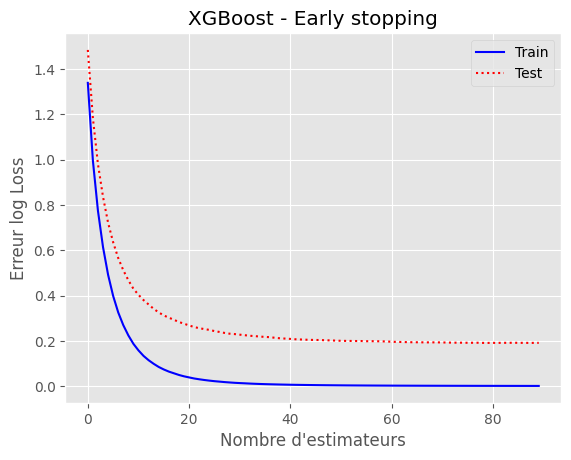

In [62]:
fig, ax = plt.subplots()

epochs = len(results1['validation_0']['mlogloss'])
x_axis = range(0, epochs)

ax.plot(x_axis, results1['validation_0']['mlogloss'], label='Train',color='blue')
ax.plot(x_axis, results1['validation_1']['mlogloss'], ':', label='Test',color='red')
ax.legend()
plt.xlabel("Nombre d'estimateurs")
plt.ylabel('Erreur log Loss')
plt.title('XGBoost - Early stopping')
plt.show()

On observe bien que l'erreur (train et test) diminue quand le nombre d'arbres augmente.
L'erreur test est toujours supérieure à celle de train. Mais compte tenu de l'échelle, la différence est légère.

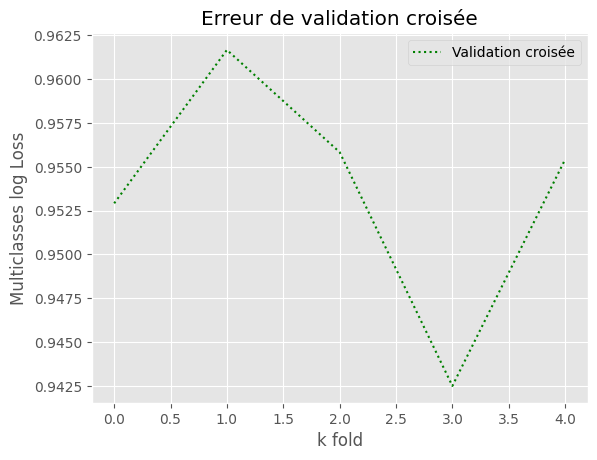

In [64]:
fig, ax = plt.subplots()

ax.plot(scores_val_cross, ':', label='Validation croisée',color='green')
ax.legend()
plt.xlabel('k fold')
plt.ylabel('Multiclasses log Loss')
plt.title('Erreur de validation croisée')
plt.show()

On va maintenant rechercher le meilleur modèle.

In [69]:
estimator = XGBClassifier(objective= 'multiclass',use_label_encoder=False, num_class=10)

parameters = {
    'max_depth': range(3, 10, 1),
    'n_estimators': range(60, 100, 20),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [70]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5,
    verbose=True
)

In [73]:
grid_search.fit(X_train, y_train, eval_metric=["mlogloss"])

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_class=10, num_parallel_tree=None,
                                     objective='multiclass', ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(3, 10),
                         'n_estimators': range(60, 100, 20)},
             scoring='accuracy', verbose=True)

In [75]:
# Résumé du meilleur score avec ses paramètres correspondants
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.948389 using {'learning_rate': 0.1, 'max_depth': 9, 'max_features': 4, 'n_estimators': 100}


In [76]:
# On cherche le meilleur modèle
print('\n\nEstimateur choisi par GridSearch :','\n\n', (grid_result.best_estimator_))



Estimateur choisi par GridSearch : 

 GradientBoostingClassifier(loss='deviance', max_depth=9, max_features=4)


In [87]:
xgboost_best = XGBClassifier(objective= 'multiclass',use_label_encoder=False, num_class=10, max_depth=9, max_features=4, random_state=0)
xgboost_best.fit(X_train, y_train, eval_metric=['mlogloss'])

[21:31:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "max_features" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_features=4, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_class=10, num_parallel_tree=1, ...)

In [88]:
y_pred = xgboost_best.predict(X_test)

In [89]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Confusion Matrix:
[[171   0   0   1   0   0   2   0   1   0]
 [  0 228   1   1   1   0   1   0   2   0]
 [  1   0 201   3   2   0   3   4   1   4]
 [  0   0   2 193   1   4   2   3   2   0]
 [  0   0   0   0 203   0   4   0   1   9]
 [  1   0   1   2   0 171   1   1   2   0]
 [  3   1   0   0   1   2 170   0   2   0]
 [  0   2  10   3   2   1   0 182   0   4]
 [  3   0   3   4   2   2   1   1 174   2]
 [  1   0   0   4   3   0   0   2   3 181]]


In [90]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       175
           1       0.99      0.97      0.98       234
           2       0.92      0.92      0.92       219
           3       0.91      0.93      0.92       207
           4       0.94      0.94      0.94       217
           5       0.95      0.96      0.95       179
           6       0.92      0.95      0.94       179
           7       0.94      0.89      0.92       204
           8       0.93      0.91      0.92       192
           9       0.91      0.93      0.92       194

    accuracy                           0.94      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.94      0.94      0.94      2000



On obtient un score d'accuracy de 0.94 qui est très bien comparé au 0.84 obtenu avec le premier modèle.

### Variante LightGBM

In [92]:
# Version simple du modèle sans optimisation
model = LGBMClassifier(objective='multiclass', num_class=10, random_state=0)
model.fit(X_train, y_train)

LGBMClassifier(num_class=10, objective='multiclass', random_state=0)

In [96]:
y_pred=model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy (test): %.2f%%" % (accuracy * 100.0)) # 94.5 %

Accuracy (test): 94.50%


In [94]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[172   0   0   1   0   0   2   0   0   0]
 [  0 230   1   1   0   0   1   0   1   0]
 [  1   0 202   2   2   0   4   4   1   3]
 [  0   0   3 196   0   2   1   2   3   0]
 [  1   0   0   0 206   0   3   0   1   6]
 [  0   0   1   2   0 172   0   1   3   0]
 [  3   1   0   0   0   2 170   0   3   0]
 [  1   3   9   2   2   1   0 182   2   2]
 [  2   0   4   2   2   1   1   2 176   2]
 [  1   0   0   2   2   0   0   2   3 184]]


In [95]:
# Simplification du modèle
eval_set = [(X_train, y_train), (X_test, y_test)]

model1 = LGBMClassifier(objective='multiclass', n_estimators=500, max_depth=10)

model1.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=['multi_logloss'], eval_set=eval_set)

[1]	training's multi_logloss: 1.6483	valid_1's multi_logloss: 1.73278
[2]	training's multi_logloss: 1.33155	valid_1's multi_logloss: 1.45715
[3]	training's multi_logloss: 1.11097	valid_1's multi_logloss: 1.26275
[4]	training's multi_logloss: 0.944578	valid_1's multi_logloss: 1.11508
[5]	training's multi_logloss: 0.809988	valid_1's multi_logloss: 0.996117
[6]	training's multi_logloss: 0.701553	valid_1's multi_logloss: 0.898546
[7]	training's multi_logloss: 0.61145	valid_1's multi_logloss: 0.816075
[8]	training's multi_logloss: 0.535154	valid_1's multi_logloss: 0.747976
[9]	training's multi_logloss: 0.470274	valid_1's multi_logloss: 0.687762
[10]	training's multi_logloss: 0.414813	valid_1's multi_logloss: 0.636417
[11]	training's multi_logloss: 0.366824	valid_1's multi_logloss: 0.592275
[12]	training's multi_logloss: 0.325217	valid_1's multi_logloss: 0.552353
[13]	training's multi_logloss: 0.289148	valid_1's multi_logloss: 0.519825
[14]	training's multi_logloss: 0.257206	valid_1's multi_

LGBMClassifier(max_depth=10, n_estimators=500, objective='multiclass')

In [97]:
print(model1.best_iteration_)

86


In [99]:
y_pred=model1.predict(X_test, num_iteration=model.best_iteration_)

In [100]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.20%


In [101]:
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[172   0   0   1   0   0   2   0   0   0]
 [  0 229   1   1   1   0   1   0   1   0]
 [  1   0 203   2   1   0   4   4   1   3]
 [  0   0   5 194   0   2   1   2   1   2]
 [  1   0   0   0 207   0   3   0   1   5]
 [  0   0   1   3   0 171   0   1   3   0]
 [  3   1   1   0   1   2 169   0   2   0]
 [  1   3  10   3   1   1   0 182   1   2]
 [  2   0   4   2   3   2   1   2 175   1]
 [  1   0   0   1   3   0   0   2   5 182]]


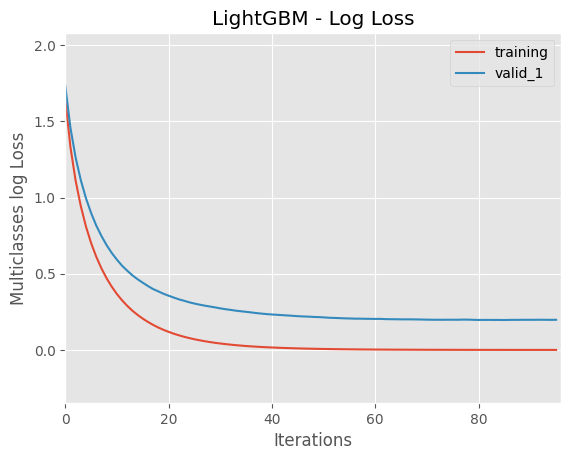

In [102]:
lgb.plot_metric(model1)
plt.ylabel('Multiclasses log Loss')
plt.title('LightGBM - Log Loss')
plt.show()

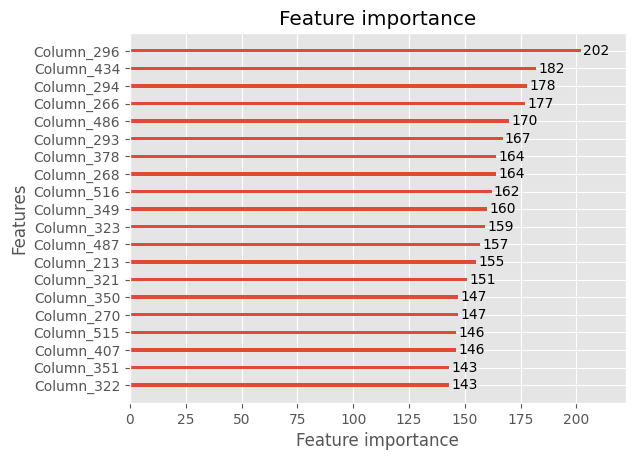

In [103]:
lgb.plot_importance(model1, max_num_features=20)
plt.show()

Le résultat n'est pas meilleur mais la complexité du modèle a été réduite.
Seulement 86 arbres sont utilisés.

On va maintenant chercher le meilleur modèle.

In [105]:
model = LGBMClassifier(objective='multiclass')

gridParams = {
    'learning_rate': [0.005, 0.01, 0.1],
    'n_estimators': [16,24,48],
    'num_leaves': [12,16,24],                   # améliore l'accuracy mais peut entrainer du sur-apprentissage
    'boosting_type' : ['gbdt','dart'],          # améliore l'accuracy
    'max_bin':[124, 255],                       # améliore l'accuracy mais ralenti la recherche
    'colsample_bytree' : [0.63, 0.64, 0.65],
    }

grid = GridSearchCV(estimator=model, param_grid=gridParams, verbose=1, cv=5, n_jobs=-1, scoring='accuracy')

grid.fit(X_train, y_train)

# Print the best paramètres trouvés
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.1, 'max_bin': 124, 'n_estimators': 48, 'num_leaves': 24}
0.9525


In [107]:
lightgbm_best = LGBMClassifier(
    objective='multiclass', 
    boosting_type = 'gbdt', 
    colsample_bytree = 0.64, 
    n_estimators=48, 
    learning_rate=0.1, 
    max_bin=124, 
    num_leaves = 24, 
    random_state=0)

In [109]:
lightgbm_best.fit(X_train, y_train)
y_pred = lightgbm_best.predict(X_test)

In [112]:
y_pred

array([2, 1, 0, ..., 9, 5, 6], dtype=int64)

In [110]:
print("Matrice de Confusion:")
print(confusion_matrix(y_test, y_pred))

Matrice de Confusion:
[[172   0   0   1   0   0   2   0   0   0]
 [  0 227   1   1   1   0   2   0   2   0]
 [  1   0 201   1   2   0   5   4   2   3]
 [  0   0   3 192   1   2   3   2   2   2]
 [  1   0   0   0 198   1   4   0   3  10]
 [  1   0   1   3   0 169   2   1   2   0]
 [  2   1   0   0   1   3 170   0   2   0]
 [  1   3   8   3   1   2   0 181   1   4]
 [  2   0   4   3   4   2   1   1 173   2]
 [  1   0   0   4   2   0   0   1   3 183]]


In [111]:
print("Classification Report")
print(classification_report(y_test, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       175
           1       0.98      0.97      0.98       234
           2       0.92      0.92      0.92       219
           3       0.92      0.93      0.93       207
           4       0.94      0.91      0.93       217
           5       0.94      0.94      0.94       179
           6       0.90      0.95      0.92       179
           7       0.95      0.89      0.92       204
           8       0.91      0.90      0.91       192
           9       0.90      0.94      0.92       194

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000



On obtient un très bon score de 0.93.